<a href="https://colab.research.google.com/github/claudiotancredi/mlinapptests/blob/main/Stage_2_transfer_learning_RNGN12_on_CNGA12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-fe52e0b6-6cf3-6bb0-52cb-721302dbf25d)


### Clone GitHub repo

In [2]:
!git clone https://github.com/claudiotancredi/Machine-learning-in-applications

Cloning into 'mlinapptests'...
remote: Enumerating objects: 861, done.
remote: Counting objects: 100% (277/277), done.
remote: Compressing objects: 100% (153/153), done.
remote: Total 861 (delta 159), reused 214 (delta 124), pack-reused 584
Receiving objects: 100% (861/861), 218.58 MiB | 12.26 MiB/s, done.
Resolving deltas: 100% (412/412), done.
Checking out files: 100% (201/201), done.


### Initialization

In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import tensorflow as tf
import glob
import sys
import random
import datetime
import PIL

### Mount Drive
It is supposed to include a "2022-DC03" path with "images.zip" of ALL the images.  
THIS NOTEBOOK NEEDS TO BE RUN AFTER THE STAGE1 MRCNN.

In [4]:
# Mount the Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Directory to save logs and trained model
tool = "CNGA12"      # This is the second component, the new one we want to finetune
MODEL_DIR = os.path.join("/content/drive/MyDrive/2022-DC03/stage2", "logs")
TRAIN_DIR = os.path.join("/content/drive/MyDrive/2022-DC03/stage2/dataset_s1mrcnn_"+tool, "train")
TEST_DIR = os.path.join("/content/drive/MyDrive/2022-DC03/stage2/dataset_s1mrcnn_"+tool, "test")

### Visualize data

In [6]:
image_count_train = len(list(glob.glob(TRAIN_DIR + '/*/*.jpg')))
image_count_test = len(list(glob.glob(TEST_DIR + '/*/*.jpg')))
print("Number of images for train and validation: ", image_count_train)
print("Number of images for test: ", image_count_test)

Number of images for train and validation:  394
Number of images for test:  129


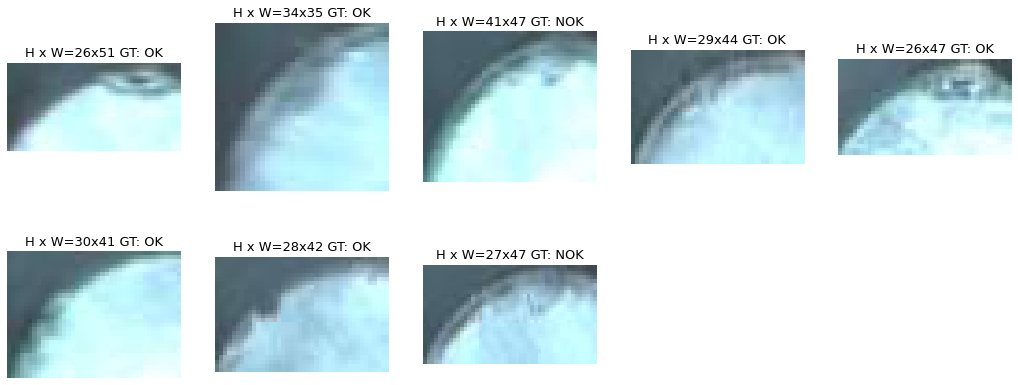

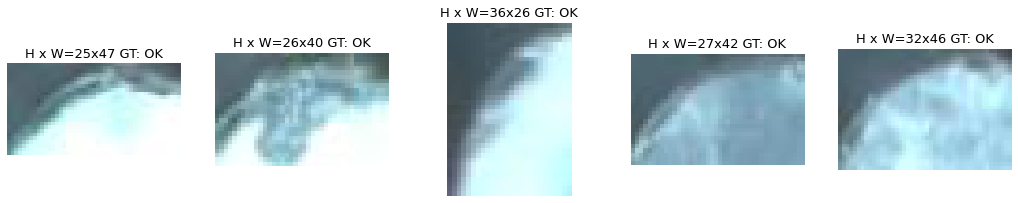

In [7]:
SRC_DIR = os.path.abspath("/content/mlinapptests/src/models/Stage2_ResNet50")

sys.path.append(SRC_DIR)

from utils import visualize_n_random_samples

visualize_n_random_samples(TRAIN_DIR, 8)
visualize_n_random_samples(TEST_DIR, 5)

In [8]:
batch_size = 4
img_height = 120
img_width = 120
# resize is automatically performed

# Generalization test - Evaluation from RNGN12 to CNGA12
No training, just evaluation.

In [9]:
data_augmentation = tf.keras.Sequential(
    [tf.keras.layers.RandomFlip("horizontal_and_vertical"), tf.keras.layers.RandomRotation(0.25)]
)

base_model = tf.keras.applications.ResNet50(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(img_height, img_width, 3),
    include_top=False)


94781440/94765736 [==============================] - 1s 0us/step


In [10]:
SRC_DIR = os.path.abspath("/content/mlinapptests/src/models/Stage2_ResNet50")

sys.path.append(SRC_DIR)

from model import net 

model = net(base_model, data_augmentation, img_height, img_width)

In [11]:
# Load back already trained on first component type weights
base_model_path = '/content/drive/MyDrive/2022-DC03/stage2/logs/tool_wear_RNGN12_STAGE2_RESNET50_20220714T2315/resnet50_tool_wear.h5'    # This is the model on which the resnet was already trained
model.load_weights(base_model_path)

In [12]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [13]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  TEST_DIR,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle=False)

Found 124 files belonging to 3 classes.


In [14]:
import json

dataset_ok = test_ds.unbatch().filter(lambda image, label: label == 2).batch(4)
dataset_nok = test_ds.unbatch().filter(lambda image, label: label == 1).batch(4)
dataset_doubt = test_ds.unbatch().filter(lambda image, label: label == 0).batch(4)
count_ok = len(list(dataset_ok.unbatch().enumerate(start=0).as_numpy_iterator()))
count_nok = len(list(dataset_nok.unbatch().enumerate(start=0).as_numpy_iterator()))
count_doubt = len(list(dataset_doubt.unbatch().enumerate(start=0).as_numpy_iterator()))
print("Total number of images in test set (only images not already predicted by stage 1): ", count_nok+count_ok+count_doubt)
print("Number of NOK images in test set (only images not already predicted by stage 1): ", count_nok)
print("Number of DOUBT images in test set (only images not already predicted by stage 1): ", count_doubt)
print("Number of OK images in test set (only images not already predicted by stage 1): ", count_ok)

JSON_PATH = "/content/drive/MyDrive/2022-DC03/stage2/output_s1mrcnn_testset_" + tool + ".json"

count_images_stage1_ok = 0
count_images_stage1_nok = 0
count_images_stage1_doubt = 0
data = ''
with open(JSON_PATH, "r") as f:
  data = json.load(f)
for element in data:
    if len(element["bbox"])==0:
        if "wo" in element["name"]:
          count_images_stage1_ok+=1
        elif "wd" in element["name"]:
          count_images_stage1_doubt+=1
        else:
          count_images_stage1_nok+=1
print("\nTotal number of images in test set already predicted by stage 1: ", count_images_stage1_nok+count_images_stage1_doubt+count_images_stage1_ok)
print("Number of NOK images in test set already predicted by stage 1: ", count_images_stage1_nok)
print("Number of DOUBT images in test set already predicted by stage 1: ", count_images_stage1_doubt)
print("Number of OK images in test set already predicted by stage 1: ", count_images_stage1_ok)

total_ts = count_images_stage1_doubt+count_images_stage1_nok+count_images_stage1_ok+count_ok+count_nok+count_doubt
print("\nTotal number of images in test set: ", total_ts)

Total number of images in test set (only images not already predicted by stage 1):  124
Number of NOK images in test set (only images not already predicted by stage 1):  9
Number of DOUBT images in test set (only images not already predicted by stage 1):  8
Number of OK images in test set (only images not already predicted by stage 1):  107

Total number of images in test set already predicted by stage 1:  6
Number of NOK images in test set already predicted by stage 1:  0
Number of DOUBT images in test set already predicted by stage 1:  0
Number of OK images in test set already predicted by stage 1:  6

Total number of images in test set:  130


In [15]:
SRC_DIR = os.path.abspath("/content/mlinapptests/src/models/Stage2_ResNet50")

sys.path.append(SRC_DIR)
from utils import predict_stats
import json

print("Evaluate on test data")

data = ''
with open(JSON_PATH, "r") as f:
  data = json.load(f)

#results = model.evaluate(test_ds)
#print("test loss, test acc:", results)

counter_ok, counter_doubt, counter_nok, counter_crit, counter_semicrit \
    = predict_stats(model, test_ds, data)

print("\nAccuracy: ", (counter_ok+counter_doubt+counter_nok)/total_ts)

print("\nOK accuracy: ", counter_ok/(count_ok+count_images_stage1_ok))
print("NOK accuracy: ", counter_nok/(count_nok+count_images_stage1_nok))
print("DOUBT accuracy: ", counter_doubt/(count_doubt+count_images_stage1_doubt))

print("\nNumber of critical wrong predictions (gt is wn, prediction is wo): ", counter_crit)
print("Number of semi-critical wrong predictions (gt is wn, prediction is wd): ", counter_semicrit)

Evaluate on test data
Ground truth was:  DOUBT  but prediction is:  NOK
Ground truth was:  DOUBT  but prediction is:  NOK
Ground truth was:  DOUBT  but prediction is:  OK
Ground truth was:  DOUBT  but prediction is:  NOK
Ground truth was:  DOUBT  but prediction is:  OK
Ground truth was:  DOUBT  but prediction is:  OK
Ground truth was:  DOUBT  but prediction is:  OK
Ground truth was:  DOUBT  but prediction is:  NOK
Ground truth was:  NOK  but prediction is:  OK
Ground truth was:  NOK  but prediction is:  OK
Ground truth was:  NOK  but prediction is:  OK
Ground truth was:  NOK  but prediction is:  OK
Ground truth was:  NOK  but prediction is:  OK
Ground truth was:  NOK  but prediction is:  OK
Ground truth was:  OK  but prediction is:  NOK
Ground truth was:  OK  but prediction is:  NOK
Ground truth was:  OK  but prediction is:  NOK
Ground truth was:  OK  but prediction is:  NOK
Ground truth was:  OK  but prediction is:  NOK
Ground truth was:  OK  but prediction is:  NOK
Ground truth was: 

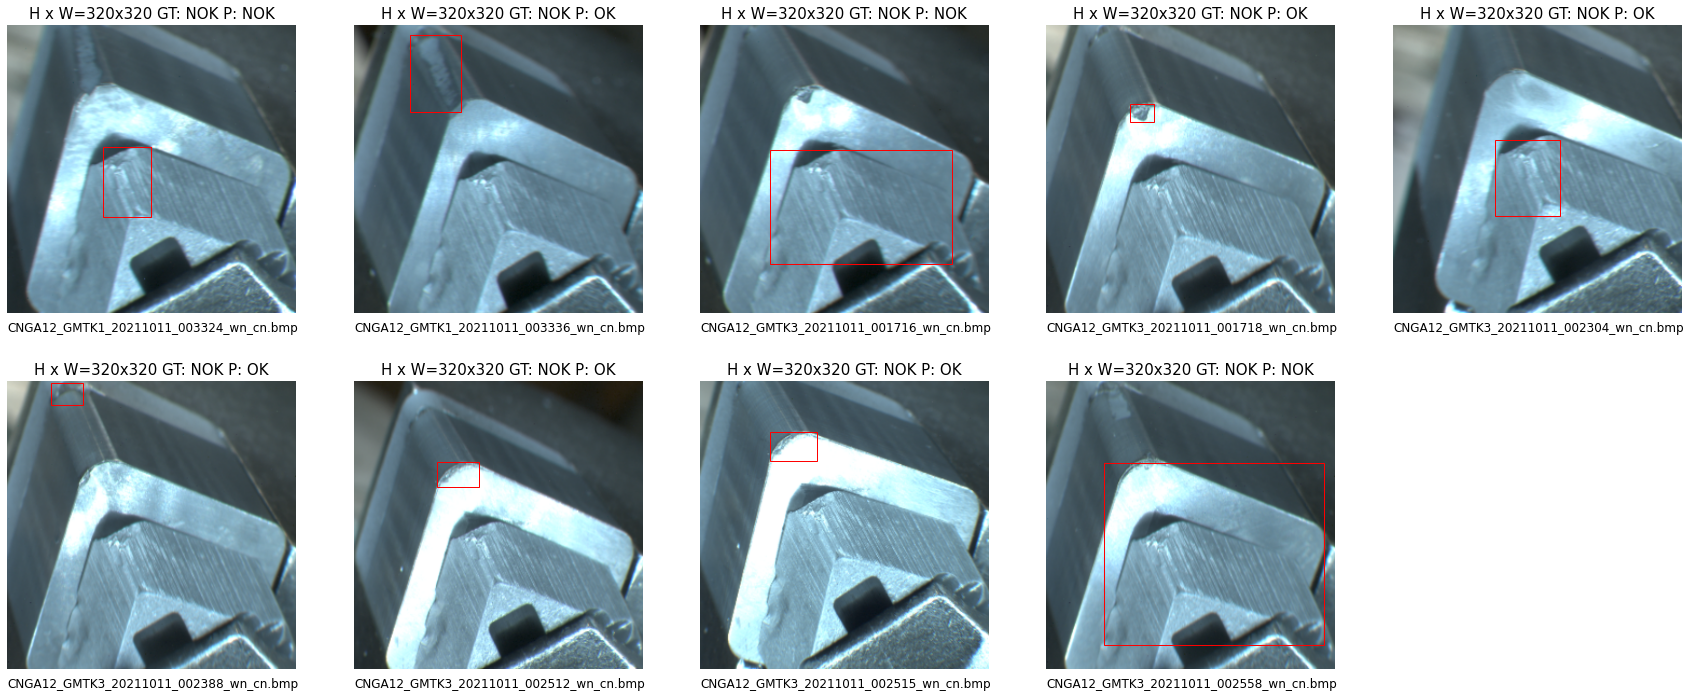

In [16]:
from utils import display_bbox, get_prediction_info
import json

ORIGINAL_IMAGES_PATH = "/content/drive/MyDrive/2022-DC03/Stage1_Mask_RCNN/images/test/"
JSON_PATH = "/content/drive/MyDrive/2022-DC03/stage2/output_s1mrcnn_testset_" + tool + ".json"

data = ''
with open(JSON_PATH, "r") as f:
  data = json.load(f)

test_ds_ok = test_ds.unbatch().filter(lambda image, label: label == 2).batch(4)
test_ds_nok = test_ds.unbatch().filter(lambda image, label: label == 1).batch(4)
test_ds_doubt = test_ds.unbatch().filter(lambda image, label: label == 0).batch(4)
ok_paths = []
[ok_paths.append(path) for path in test_ds.file_paths if "wo" in path]
nok_paths = []
[nok_paths.append(path) for path in test_ds.file_paths if "wn" in path]
doubt_paths = []
[doubt_paths.append(path) for path in test_ds.file_paths if "wd" in path]


# Get and visualize NOK test predictions
images_arr, predictions_arr, bbox_arr, names \
    = get_prediction_info(model, test_ds_nok, test_ds, nok_paths, ORIGINAL_IMAGES_PATH, data, n=10)
display_bbox(images_arr, predictions_arr, bbox_arr, names)

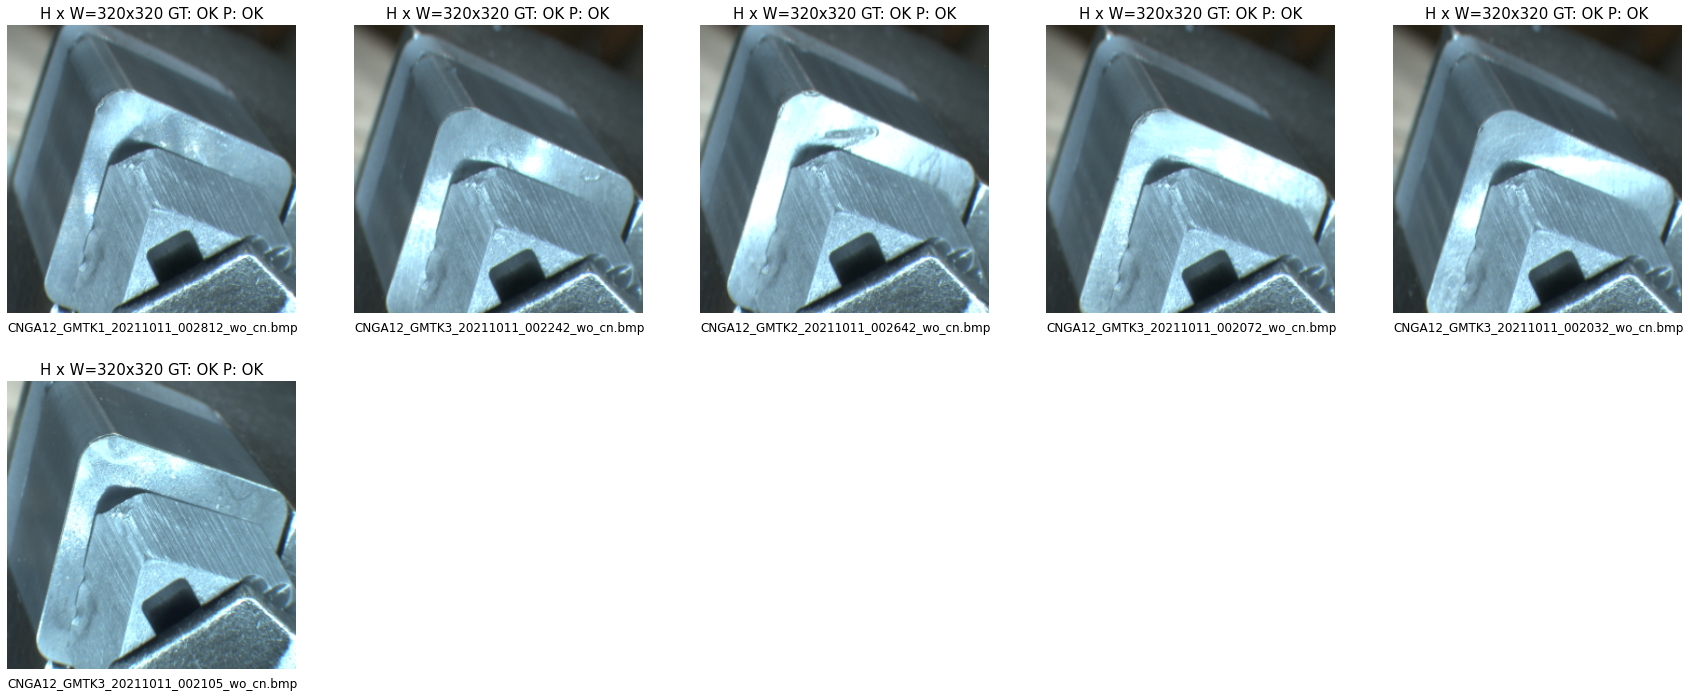

In [17]:
#Visualize predictions of stage 1 if any
import json
from utils import get_prediction_s1_info

ORIGINAL_IMAGES_PATH = "/content/drive/MyDrive/2022-DC03/Stage1_Mask_RCNN/images/test/"
JSON_PATH = "/content/drive/MyDrive/2022-DC03/stage2/output_s1mrcnn_testset_" + tool + ".json"

data = ''
with open(JSON_PATH, "r") as f:
  data = json.load(f)

images_arr, predictions_arr, names= get_prediction_s1_info(ORIGINAL_IMAGES_PATH, data)

display_bbox(images_arr, predictions_arr, None, names)

# Stage2 finetuning

In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  TRAIN_DIR,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 394 files belonging to 3 classes.
Using 316 files for training.


In [10]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  TRAIN_DIR,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 394 files belonging to 3 classes.
Using 78 files for validation.


['DOUBT', 'NOK', 'OK']


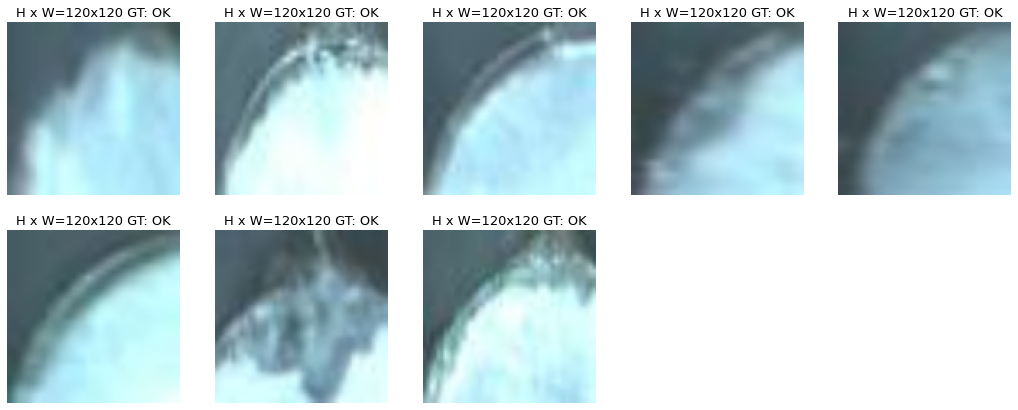

In [11]:
SRC_DIR = os.path.abspath("/content/mlinapptests/src/models/Stage2_ResNet50")

sys.path.append(SRC_DIR)

from utils import display

class_names = train_ds.class_names
print(class_names)
images_arr = []
labels_arr = []
for element in train_ds.take(8):
  images_arr.append(element[0][0].numpy())
  labels_arr.append("GT: " + class_names[element[1][0].numpy()])
display(images_arr, labels_arr)

### Model

In [12]:
log_dir = os.path.join(MODEL_DIR, "{}{}{}{}{:%Y%m%dT%H%M}".format(
                "tool_wear","_",tool,"_STAGE2_RESNET50_TRANSFER_LEARNING_", datetime.datetime.now()))
tb_log_dir = os.path.join("/content/drive/MyDrive/2022-DC03/stage2/tblogs", tool+"_STAGE2_RESNET50_TRANSFER_LEARNING_"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
checkpoint_path = os.path.join(log_dir, "resnet50_tool_wear.h5")

# Callbacks
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, verbose=1, save_weights_only=True, save_best_only=True)
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1, restore_best_weights=True)
tb_callback = tf.keras.callbacks.TensorBoard(tb_log_dir, update_freq="epoch")

In [13]:
data_augmentation = tf.keras.Sequential(
    [tf.keras.layers.RandomFlip("horizontal_and_vertical"), tf.keras.layers.RandomRotation(0.25)]
)

base_model = tf.keras.applications.ResNet50(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(img_height, img_width, 3),
    include_top=False)


94781440/94765736 [==============================] - 0s 0us/step


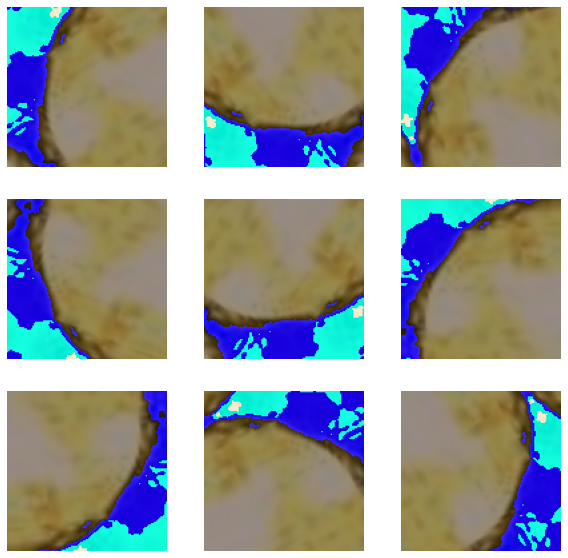

In [14]:
SRC_DIR = os.path.abspath("/content/mlinapptests/src/models/Stage2_ResNet50")

sys.path.append(SRC_DIR)

from utils import visualize_after_data_augm

visualize_after_data_augm(train_ds, data_augmentation)

In [15]:
base_model.trainable = True

In [16]:
SRC_DIR = os.path.abspath("/content/mlinapptests/src/models/Stage2_ResNet50")

sys.path.append(SRC_DIR)

from model import net 

model = net(base_model, data_augmentation, img_height, img_width)

In [17]:
# Load back already trained on first component type weights
base_model_path = '/content/drive/MyDrive/2022-DC03/stage2/logs/tool_wear_RNGN12_STAGE2_RESNET50_20220714T2315/resnet50_tool_wear.h5'    # This is the model on which the resnet was already trained
model.load_weights(base_model_path)

In [18]:
base_model.trainable = False

In [ ]:
%load_ext tensorboard

In [ ]:
import shutil
import glob

if os.path.exists("/content/drive/MyDrive/2022-DC03/stage2/tblogs"):
  for match in glob.glob("/content/drive/MyDrive/2022-DC03/stage2/tblogs/*"):
    shutil.rmtree(match)

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 120, 120, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 120, 120, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 120, 120, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                      

In [20]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [21]:
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
history = model.fit(train_ds, epochs=100,  validation_data=val_ds, callbacks=[tb_callback, es_callback, cp_callback])

Epoch 1/100
76/79 [===========================>..] - ETA: 0s - loss: 0.7640 - sparse_categorical_accuracy: 0.8388
Epoch 1: val_loss improved from inf to 0.58891, saving model to /content/drive/MyDrive/2022-DC03/stage2/logs/tool_wear_CNGA12_STAGE2_RESNET50_TRANSFER_LEARNING_20220716T2200/resnet50_tool_wear.h5
79/79 [==============================] - 28s 205ms/step - loss: 0.8076 - sparse_categorical_accuracy: 0.8323 - val_loss: 0.5889 - val_sparse_categorical_accuracy: 0.9103
Epoch 2/100
79/79 [==============================] - ETA: 0s - loss: 0.5612 - sparse_categorical_accuracy: 0.8639
Epoch 2: val_loss improved from 0.58891 to 0.52582, saving model to /content/drive/MyDrive/2022-DC03/stage2/logs/tool_wear_CNGA12_STAGE2_RESNET50_TRANSFER_LEARNING_20220716T2200/resnet50_tool_wear.h5
79/79 [==============================] - 2s 23ms/step - loss: 0.5612 - sparse_categorical_accuracy: 0.8639 - val_loss: 0.5258 - val_sparse_categorical_accuracy: 0.8974
Epoch 3/100
77/79 [===================

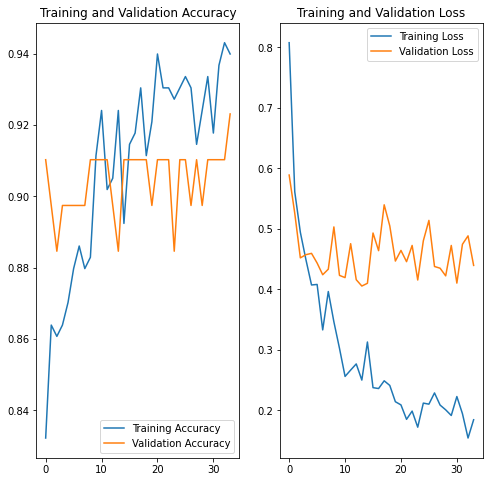

In [22]:
SRC_DIR = os.path.abspath("/content/mlinapptests/src/models/Stage2_ResNet50")

sys.path.append(SRC_DIR)

from utils import plot_history

plot_history(history)

In [23]:
SRC_DIR = os.path.abspath("/content/mlinapptests/src/models/Stage2_ResNet50")

sys.path.append(SRC_DIR)

from utils import find_last

# Load back weights
model.load_weights(find_last(MODEL_DIR, tool)) 

/content/drive/MyDrive/2022-DC03/stage2/logs/tool_wear_CNGA12_STAGE2_RESNET50_TRANSFER_LEARNING_20220716T2200/resnet50_tool_wear.h5


In [24]:
print("Evaluate on validation data")
results = model.evaluate(val_ds)
print("validation loss, validation acc:", results)


Evaluate on validation data
20/20 [==============================] - 0s 11ms/step - loss: 0.4055 - sparse_categorical_accuracy: 0.8846
validation loss, validation acc: [0.40549856424331665, 0.8846153616905212]


In [25]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  TEST_DIR,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle=False)

Found 129 files belonging to 3 classes.


In [26]:
import json

dataset_ok = test_ds.unbatch().filter(lambda image, label: label == 2).batch(4)
dataset_nok = test_ds.unbatch().filter(lambda image, label: label == 1).batch(4)
dataset_doubt = test_ds.unbatch().filter(lambda image, label: label == 0).batch(4)
count_ok = len(list(dataset_ok.unbatch().enumerate(start=0).as_numpy_iterator()))
count_nok = len(list(dataset_nok.unbatch().enumerate(start=0).as_numpy_iterator()))
count_doubt = len(list(dataset_doubt.unbatch().enumerate(start=0).as_numpy_iterator()))
print("Total number of images in test set (only images not already predicted by stage 1): ", count_nok+count_ok+count_doubt)
print("Number of NOK images in test set (only images not already predicted by stage 1): ", count_nok)
print("Number of DOUBT images in test set (only images not already predicted by stage 1): ", count_doubt)
print("Number of OK images in test set (only images not already predicted by stage 1): ", count_ok)

JSON_PATH = "/content/drive/MyDrive/2022-DC03/stage2/output_s1mrcnn_testset_" + tool + ".json"

count_images_stage1_ok = 0
count_images_stage1_nok = 0
count_images_stage1_doubt = 0
data = ''
with open(JSON_PATH, "r") as f:
  data = json.load(f)
for element in data:
    if len(element["bbox"])==0:
        if "wo" in element["name"]:
          count_images_stage1_ok+=1
        elif "wd" in element["name"]:
          count_images_stage1_doubt+=1
        else:
          count_images_stage1_nok+=1
print("\nTotal number of images in test set already predicted by stage 1: ", count_images_stage1_nok+count_images_stage1_doubt+count_images_stage1_ok)
print("Number of NOK images in test set already predicted by stage 1: ", count_images_stage1_nok)
print("Number of DOUBT images in test set already predicted by stage 1: ", count_images_stage1_doubt)
print("Number of OK images in test set already predicted by stage 1: ", count_images_stage1_ok)

total_ts = count_images_stage1_doubt+count_images_stage1_nok+count_images_stage1_ok+count_ok+count_nok+count_doubt
print("\nTotal number of images in test set: ", total_ts)

Total number of images in test set (only images not already predicted by stage 1):  129
Number of NOK images in test set (only images not already predicted by stage 1):  9
Number of DOUBT images in test set (only images not already predicted by stage 1):  8
Number of OK images in test set (only images not already predicted by stage 1):  112

Total number of images in test set already predicted by stage 1:  1
Number of NOK images in test set already predicted by stage 1:  0
Number of DOUBT images in test set already predicted by stage 1:  0
Number of OK images in test set already predicted by stage 1:  1

Total number of images in test set:  130


In [27]:
SRC_DIR = os.path.abspath("/content/mlinapptests/src/models/Stage2_ResNet50")

sys.path.append(SRC_DIR)
from utils import predict_stats
import json

print("Evaluate on test data")

data = ''
with open(JSON_PATH, "r") as f:
  data = json.load(f)

#results = model.evaluate(test_ds)
#print("test loss, test acc:", results)

counter_ok, counter_doubt, counter_nok, counter_crit, counter_semicrit \
    = predict_stats(model, test_ds, data)

print("\nAccuracy: ", (counter_ok+counter_doubt+counter_nok)/total_ts)

print("\nOK accuracy: ", counter_ok/(count_ok+count_images_stage1_ok))
print("NOK accuracy: ", counter_nok/(count_nok+count_images_stage1_nok))
print("DOUBT accuracy: ", counter_doubt/(count_doubt+count_images_stage1_doubt))

print("\nNumber of critical wrong predictions (gt is wn, prediction is wo): ", counter_crit)
print("Number of semi-critical wrong predictions (gt is wn, prediction is wd): ", counter_semicrit)

Evaluate on test data
Ground truth was:  DOUBT  but prediction is:  OK
Ground truth was:  DOUBT  but prediction is:  OK
Ground truth was:  DOUBT  but prediction is:  OK
Ground truth was:  DOUBT  but prediction is:  OK
Ground truth was:  DOUBT  but prediction is:  OK
Ground truth was:  DOUBT  but prediction is:  OK
Ground truth was:  DOUBT  but prediction is:  OK
Ground truth was:  DOUBT  but prediction is:  OK
Ground truth was:  NOK  but prediction is:  OK
Ground truth was:  NOK  but prediction is:  OK
Ground truth was:  NOK  but prediction is:  OK
Ground truth was:  NOK  but prediction is:  OK
Ground truth was:  NOK  but prediction is:  OK
Ground truth was:  NOK  but prediction is:  OK
Ground truth was:  NOK  but prediction is:  OK
Ground truth was:  NOK  but prediction is:  OK
Ground truth was:  NOK  but prediction is:  OK
Ground truth was:  OK  but prediction is:  NOK
Ground truth was:  OK  but prediction is:  NOK

Accuracy:  0.8538461538461538

OK accuracy:  0.9823008849557522
NOK 

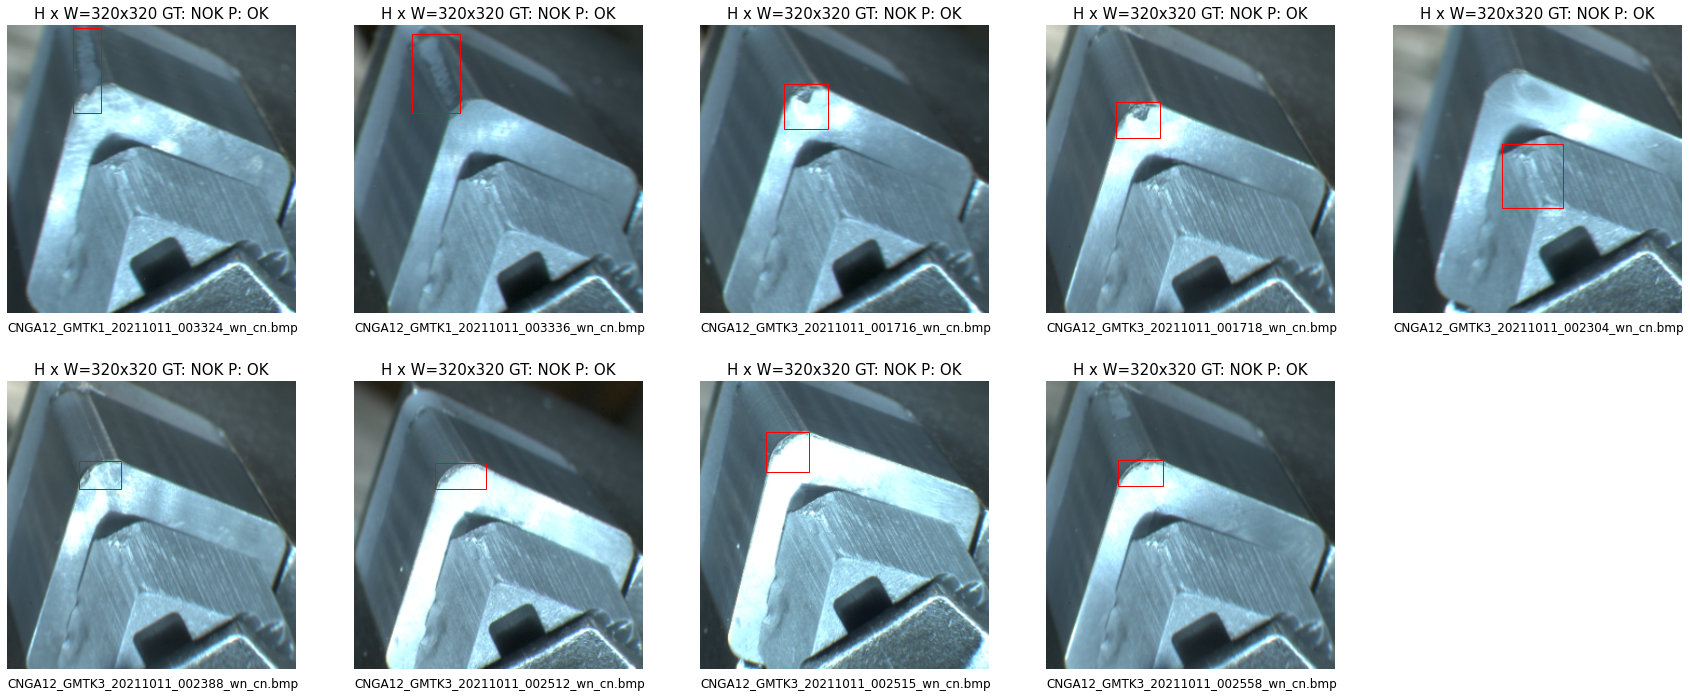

In [28]:
from utils import display_bbox, get_prediction_info
import json

ORIGINAL_IMAGES_PATH = "/content/drive/MyDrive/2022-DC03/Stage1_Mask_RCNN/images/test/"
JSON_PATH = "/content/drive/MyDrive/2022-DC03/stage2/output_s1mrcnn_testset_" + tool + ".json"

data = ''
with open(JSON_PATH, "r") as f:
  data = json.load(f)

test_ds_ok = test_ds.unbatch().filter(lambda image, label: label == 2).batch(4)
test_ds_nok = test_ds.unbatch().filter(lambda image, label: label == 1).batch(4)
test_ds_doubt = test_ds.unbatch().filter(lambda image, label: label == 0).batch(4)
ok_paths = []
[ok_paths.append(path) for path in test_ds.file_paths if "wo" in path]
nok_paths = []
[nok_paths.append(path) for path in test_ds.file_paths if "wn" in path]
doubt_paths = []
[doubt_paths.append(path) for path in test_ds.file_paths if "wd" in path]


# Get and visualize NOK test predictions
images_arr, predictions_arr, bbox_arr, names \
    = get_prediction_info(model, test_ds_nok, test_ds, nok_paths, ORIGINAL_IMAGES_PATH, data, n=10)
display_bbox(images_arr, predictions_arr, bbox_arr, names)

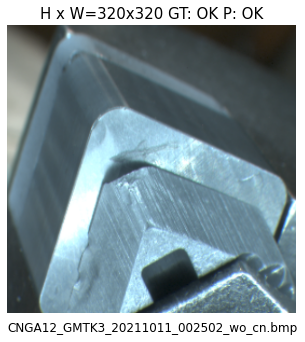

In [29]:
#Visualize predictions of stage 1 if any
import json
from utils import get_prediction_s1_info

ORIGINAL_IMAGES_PATH = "/content/drive/MyDrive/2022-DC03/Stage1_Mask_RCNN/images/test/"
JSON_PATH = "/content/drive/MyDrive/2022-DC03/stage2/output_s1mrcnn_testset_" + tool + ".json"

data = ''
with open(JSON_PATH, "r") as f:
  data = json.load(f)

images_arr, predictions_arr, names= get_prediction_s1_info(ORIGINAL_IMAGES_PATH, data)

display_bbox(images_arr, predictions_arr, None, names)